In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from datetime import timedelta


In [2]:
fg_df = pd.read_csv('fear_greed_index.csv')


In [3]:
fg_df.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:
fg_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [5]:
fg_df['datetime'] = pd.to_datetime(fg_df['date'])


In [6]:
fg_df.set_index('datetime',inplace=True)
fg_df.sort_index(inplace=True)


In [7]:
fg_df.head()


,timestamp,value,classification,date
datetime,,,,
2018-02-01,1517463000,30,Fear,2018-02-01
2018-02-02,1517549400,15,Extreme Fear,2018-02-02
2018-02-03,1517635800,40,Fear,2018-02-03
2018-02-04,1517722200,24,Extreme Fear,2018-02-04
2018-02-05,1517808600,11,Extreme Fear,2018-02-05


In [8]:
hl_df = pd.read_csv('historical_data.csv')


In [9]:
hl_df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [10]:
hl_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [11]:
hl_df['Timestamp'] = pd.to_numeric(hl_df['Timestamp'],errors='coerce')
hl_df['datetime'] = pd.to_datetime(hl_df['Timestamp'],unit='ms',errors = 'coerce')


hl_df.loc[hl_df['datetime'].isna(),'datetime'] = pd.to_datetime( hl_df.loc[hl_df['datetime'].isna(),'Timestamp'],unit='s',errors = 'coerce')
hl_df.set_index('datetime',inplace=True)


In [12]:
closed_trades = hl_df[hl_df['Direction'].str.contains('Close',na = False)].copy()


In [13]:
closed_trades['closedPnL'] = pd.to_numeric(closed_trades['Closed PnL'],errors = 'coerce')


In [14]:
fg_resampled = fg_df.resample('min').ffill()


In [15]:
merged_df = closed_trades.join(fg_resampled[['classification','value']],how = 'left')


In [16]:
merged_df.dropna(subset=['classification'],inplace=True)


In [17]:
merged_df['trade_direction'] = np.where(merged_df['Side'] == 'BUY','Long','Short')
def classify_sentiment(score):
    if score <20:
        return 'Extreme Fear'
    elif 20 <= score < 40 :
        return 'Fear'
    elif 40 <= score <60:
        return 'Neutral'
    elif 60 <= score <= 80:
        return 'Greedy'
    else :
        return 'Extreme Greed'

merged_df['sentiment_bin'] = merged_df['value'].apply(classify_sentiment)


In [44]:
pref_by_sentiment = merged_df.groupby('classification')['closedPnL'].agg(['mean','std','count','sum'])
print('\n Average PnL by Market Sentiment:')
print(pref_by_sentiment)
extreme_fear_pnl = merged_df[merged_df['classification'] == 'Extreme Fear']['closedPnL']
extreme_greed_pnl = merged_df[merged_df['classification'] == 'Extreme Greed']['closedPnL']


t_stat,p_val = stats.ttest_ind(extreme_fear_pnl,extreme_greed_pnl,nan_policy='omit')



 Average PnL by Market Sentiment:
                      mean          std  count           sum
classification                                              
Extreme Greed    40.348434   386.995727   4320  1.743052e+05
Fear            113.883873  1371.341229  56787  6.467123e+06


/home/aman/miniconda3/envs/my12/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [19]:
merged_df['win'] = merged_df['closedPnL']>0
win_rate_by_sentiment = merged_df.groupby('classification')['win'].mean().sort_values(ascending=False)
print('\n Win rate by Sentiment')
print(win_rate_by_sentiment)



 Win rate by Sentiment
classification
Fear             0.874197
Extreme Greed    0.785648
Name: win, dtype: float64


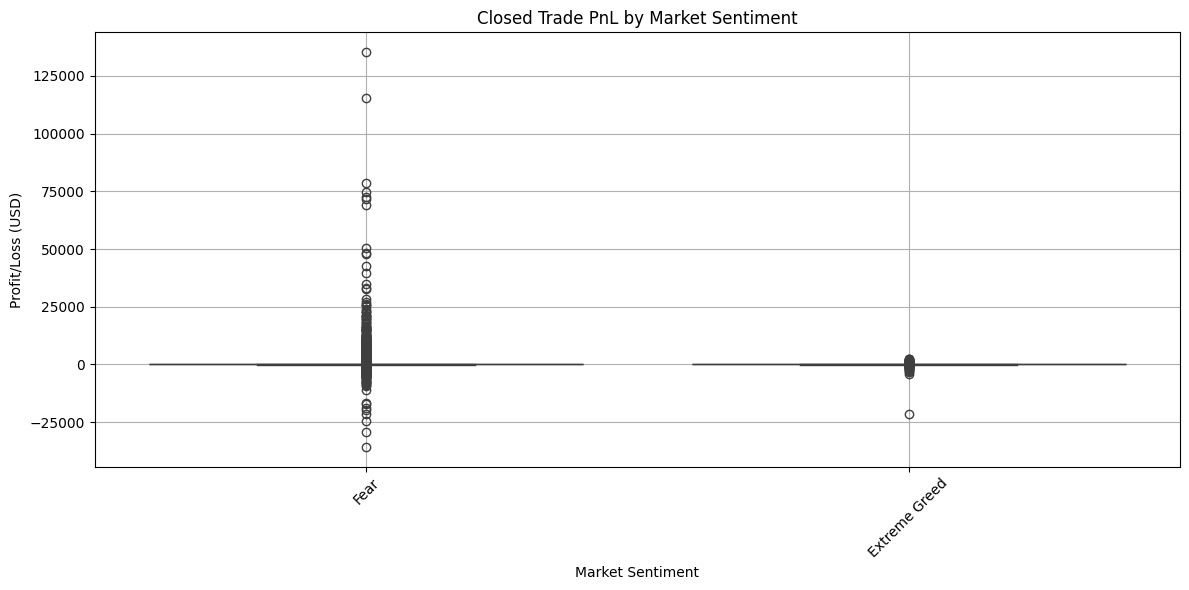

In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(x='classification',y='closedPnL',data=merged_df)
plt.title('Closed Trade PnL by Market Sentiment')
plt.ylabel('Profit/Loss (USD)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


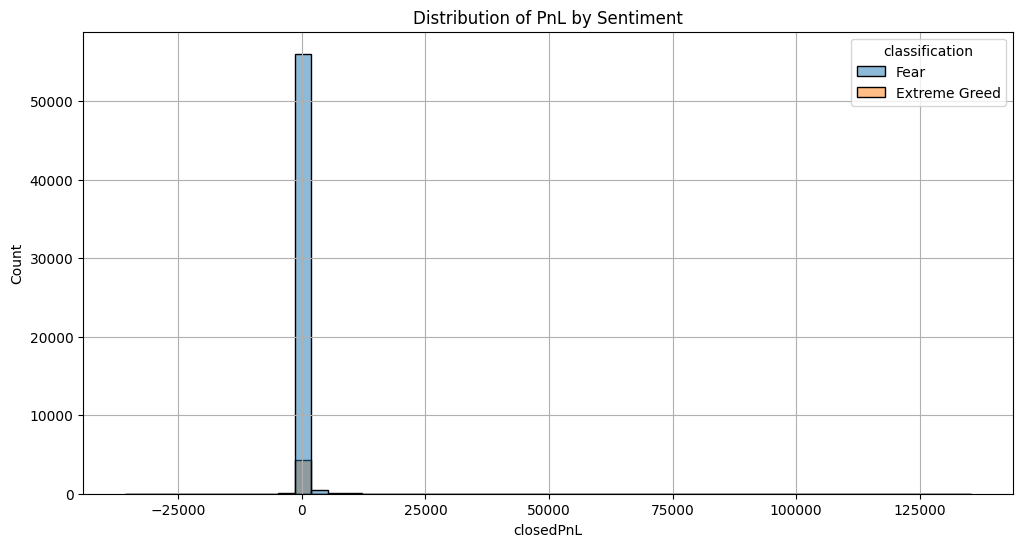

In [21]:
plt.figure(figsize=(12,6))
sns.histplot(data=merged_df,x = 'closedPnL',hue = 'classification',bins = 50,alpha=0.5)
plt.title('Distribution of PnL by Sentiment')
plt.grid(True)
plt.show()


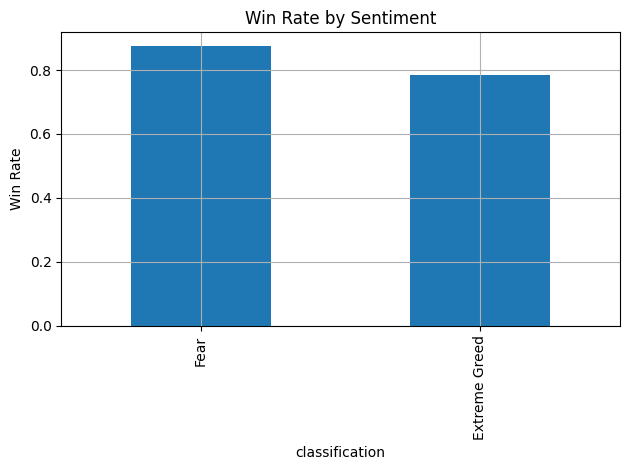

In [22]:
win_rate_by_sentiment.plot(kind='bar',title = 'Win Rate by Sentiment')
plt.ylabel('Win Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
merged_df['signal'] = np.where(merged_df['classification'] == 'Extreme Fear','Buy', np.where(merged_df['classification'] == 'Extreme Greed', 'Sell' , 'Hold'))


In [24]:
signal_counts = merged_df['signal'].value_counts()
print('\nTrade Signal Count:')
print(signal_counts)



Trade Signal Count:
signal
Hold    56787
Sell     4320
Name: count, dtype: int64


In [25]:
signal_Pnl = merged_df.groupby('signal')['closedPnL'].mean()
print('\nAverage PnL per signal:\n', signal_Pnl)



Average PnL per signal:
 signal
Hold    113.883873
Sell     40.348434
Name: closedPnL, dtype: float64


In [26]:
top_traders = merged_df.groupby('Account')['closedPnL'].sum().sort_values(ascending=False).head()
print('\nTop Performing Traders (Total Profit):')
print(top_traders)



Top Performing Traders (Total Profit):
Account
0x083384f897ee0f19899168e3b1bec365f52a9012    1.926566e+06
0xbaaaf6571ab7d571043ff1e313a9609a10637864    9.401258e+05
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4    6.133278e+05
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    5.378140e+05
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3    3.499599e+05
Name: closedPnL, dtype: float64


In [27]:
best_symbol = merged_df.groupby('Coin')['closedPnL'].sum().sort_values(ascending=False)
print("\nBest Performing Symbol:")
print(best_symbol)



Best Performing Symbol:
Coin
HYPE        1.834691e+06
ETH         1.434676e+06
SOL         1.361966e+06
BTC         5.619339e+05
MELANIA     3.155805e+05
                ...     
NIL        -3.175274e+03
AAVE       -4.324187e+03
S          -8.644846e+03
ADA        -2.876066e+04
FARTCOIN   -1.078518e+05
Name: closedPnL, Length: 153, dtype: float64


In [28]:
correlation = merged_df['value'].corr(merged_df['closedPnL'])
print(f'Correlation between Sentiment Score and closedPnL: {correlation}')



Correlation between Sentiment Score and closedPnL: -0.014213341277215553


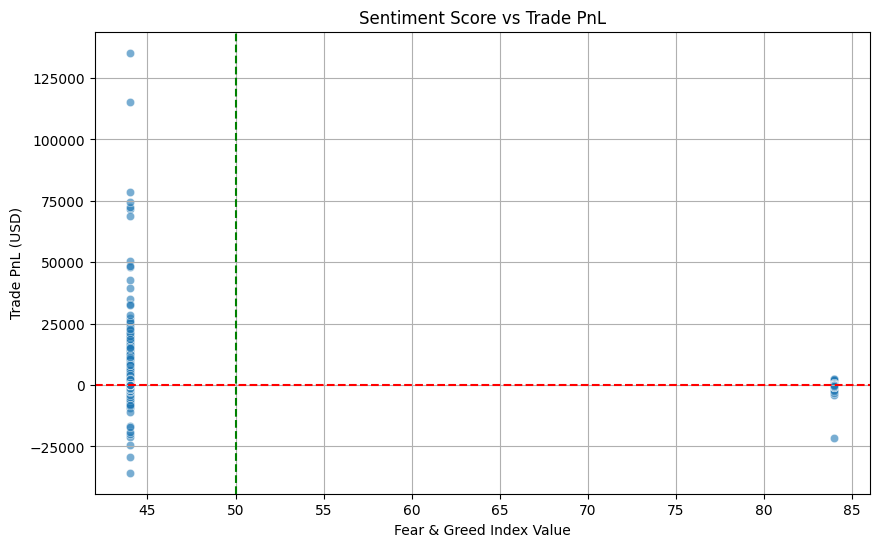

In [29]:


plt.figure(figsize=(10,6))
sns.scatterplot(x='value', y='closedPnL', data=merged_df,alpha = 0.6)
plt.axhline(0,color='r',linestyle='--')
plt.axvline(50,color='g',linestyle='--')
plt.title('Sentiment Score vs Trade PnL')
plt.xlabel('Fear & Greed Index Value')
plt.ylabel('Trade PnL (USD)')
plt.grid(True)
plt.show()


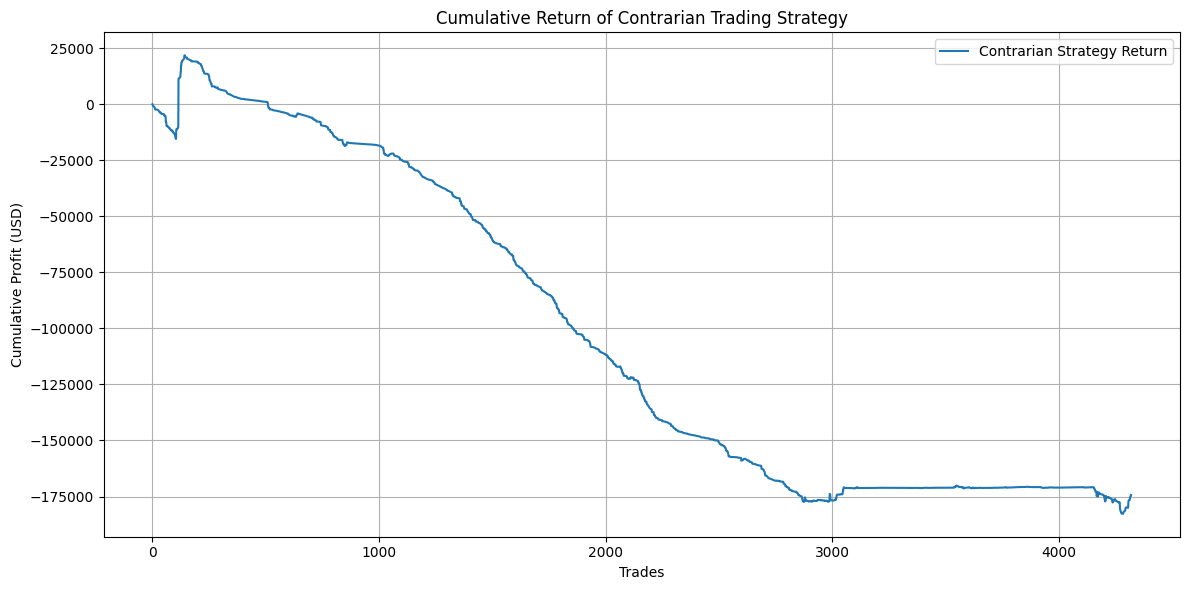

In [30]:
contrarian_returns = []
for idx,row in merged_df.iterrows():
    if row['classification'] == 'Extreme Fear':
        contrarian_returns.append(row['closedPnL'])
    elif row['classification'] == 'Extreme Greed':
        contrarian_returns.append(-row['closedPnL'])

cumulative_return = np.cumsum(contrarian_returns)

plt.figure(figsize=(12,6))
plt.plot(cumulative_return,label = 'Contrarian Strategy Return')
plt.title('Cumulative Return of Contrarian Trading Strategy')
plt.xlabel("Trades")
plt.ylabel('Cumulative Profit (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
